# TriAD Data Science Take-Me-Home Challenge

## Package Import

In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, classification_report

## Data Import

In [2]:
load_dotenv()
DB_STRING = os.getenv('DB_STRING')
db = create_engine(DB_STRING)
query_string = "SELECT * FROM takemehome.triad"
df_raw = pd.read_sql(query_string, db)

## Data Overview

As seen in the analysis below, the data consist of 5000 datapoints, described by the following features, including initial assumptions about their contextual meaning:

| Feature | Description |
|---|---|
| sex| whether participant is Female or Male|
| lang| spoken mother tongue: ['Japanese', 'Finnish', 'English', 'Spanish', 'French', 'Italian']|
| country| country of origin: ['Japan', 'Finland', 'Australia', 'Mexico', 'New Zealand', 'USA','UK', 'Spain', 'France', 'Italy']|
| age| age of the participant|
| hours_studied| how many hours the participant prepared for the test|
| dojo_class| whether the participant took the "Dojo class" in preparation for the test|
| test_prep| whether the participant took a "test prep" course, or participated in a preparatory mock-test. either way, this feature is not dependent on whether or not the student has more than 0 hours_studied or taken the Dojo-class|
| pass| whether the student passed the test|
| notes| custom notes on the student. These are mostly empty, but occasionally contain anything from javascript snippets to emojis. This column is not useful for a data analysis, but very entertaining to browse through. I especially liked '̗̺͖̹̯͓Ṯ̤͍̥͇͈h̲́e͏͓̼̗̙̼̣͔ ͇̜̱̠͓͍ͅN͕͠e̗̱z̘̝̜̺͙p̤̺̹͍̯͚e̠̻̠͜r̨̤͍̺̖͔̖̖d̠̟̭̬̝͟i̦͖̩͓͔̤a̠̗̬͉̙n͚͜ ̻̞̰͚ͅh̵͉i̳̞v̢͇ḙ͎͟-҉̭̩̼͔m̤̭̫i͕͇̝̦n̗͙ḍ̟ ̯̲͕͞ǫ̟̯̰̲͙̻̝f ̪̰̰̗̖̭̘͘c̦͍̲̞͍̩̙ḥ͚a̮͎̟̙͜ơ̩̹͎s̤.̝̝ ҉Z̡̖̜͖̰̣͉̜a͖̰͙̬͡l̲̫̳͍̩g̡̟̼̱͚̞̬ͅo̗͜.̟'.

In [3]:
print("Value overviews")
display(df_raw.describe(include="all"))
print("General Info on the data:")
display(df_raw.info())
print("Sample of the dataset")
display(df_raw.sample(10))

Value overviews


,sex,lang,country,age,hours_studied,dojo_class,test_prep,pass,notes
count,5000,5000,5000,5000.000000,3018.000000,5000,5000,5000,772
unique,2,6,10,NaN,NaN,2,2,2,393
top,Male,Japanese,Japan,NaN,NaN,False,False,False,CON
freq,3719,4022,4022,NaN,NaN,3518,3986,2665,6
mean,NaN,NaN,NaN,25.873400,4.964076,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,7.349978,3.203037,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,18.000000,0.139203,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,20.000000,2.555823,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,24.000000,4.247235,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,30.000000,6.660737,NaN,NaN,NaN,NaN


General Info on the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex            5000 non-null   object 
 1   lang           5000 non-null   object 
 2   country        5000 non-null   object 
 3   age            5000 non-null   int64  
 4   hours_studied  3018 non-null   float64
 5   dojo_class     5000 non-null   bool   
 6   test_prep      5000 non-null   bool   
 7   pass           5000 non-null   bool   
 8   notes          772 non-null    object 
dtypes: bool(3), float64(1), int64(1), object(4)
memory usage: 249.1+ KB


None

Sample of the dataset


,sex,lang,country,age,hours_studied,dojo_class,test_prep,pass,notes
4914,Male,Japanese,Japan,37,8.248113,False,False,True,None
1061,Male,Japanese,Japan,22,4.650924,True,False,True,None
2082,Male,Japanese,Japan,22,NaN,False,False,True,""""
2900,Male,Japanese,Japan,20,3.282583,True,True,False,None
4305,Male,English,UK,18,4.458791,True,False,True,"""`'><script>\x3Bjavascript:alert(1)</script>"
2051,Male,Finnish,Finland,34,NaN,False,False,False,None
3502,Male,Japanese,Japan,18,2.040265,False,False,False,None
2806,Female,Italian,Italy,30,2.617772,True,False,False,None
2400,Male,Japanese,Japan,21,2.378342,False,False,True,None
4023,Male,Japanese,Japan,24,NaN,False,False,False,None


In [4]:
display(df_raw.lang.unique())
display(df_raw.country.unique())

array(['Japanese', 'Finnish', 'English', 'Spanish', 'French', 'Italian'],
      dtype=object)

array(['Japan', 'Finland', 'Australia', 'Mexico', 'New Zealand', 'USA',
       'UK', 'Spain', 'France', 'Italy'], dtype=object)

## Cleanup and encoding

We can get rid of the notes column, convert the binary features to 0 and 1 and 1hot encode the categorical features to have a look at some correlations. finally, we're filling the missing hours_studied values. Since none of the entries are 0, filling with zeroes wouldn't be suitable. To avoid bias and stay within thsi projects time constraints, all empty cells are filled with the average value.

I'm also splitting an EDA-friendly version of the Dataframe, to allow for some better plotting options

In [5]:
#create a backup of the original df
df = df_raw

#encode binary columns
df["is_female"] = [1 if i == "Female" else 0 for i in df.sex]
df.dojo_class = df.dojo_class.astype(int)
df.test_prep = df.test_prep.astype(int)
df["pass"] = df["pass"].astype(int)

# fill in missing hours_studied values with their mean value
df.hours_studied.fillna(value = df.hours_studied.mean(), inplace=True)


#split a more EDA-friendly version of the DF here, because 1-hot encoded data are hard to read
eda_df = df.copy(deep=True)
eda_df.lang = eda_df.lang.astype("category")
eda_df.country = eda_df.country.astype("category")
eda_df["prep"] = ["both" if dojo == 1 and test == 1 else "dojo class" if dojo == 1 else "test prep" if test == 1 else "neither" for dojo,test in np.array(eda_df[["dojo_class","test_prep"]])]
eda_df['country_count'] = eda_df.groupby('country')["country"].transform("count")
eda_df['lang_count'] = eda_df.groupby('lang')["lang"].transform("count")



# 1hot-encode language and country
col = pd.get_dummies(df[['lang', 'country']])
df = pd.concat([col,df],axis=1)

# drop useless or redundant columns
df = df.drop(["sex","lang","country","notes"], axis=1) 


## EDA

53% of all participants pass the test.

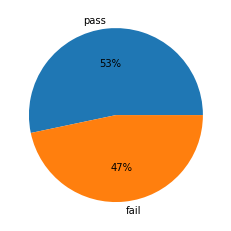

In [6]:
plt.pie(x=list(eda_df.groupby('pass')["pass"].count()), colors = sns.color_palette(),autopct='%.0f%%', labels = ["pass","fail"])
plt.show()

We see an overwhelming majority of japanese participants, followed by italians and anglophonic nationalities, as well as the french.
among those groups, only the americans have a failure rate of over 50%. 
With exception of the very underrepresented Finns, most nationalities have an approximate failure rate around a little less than 50%

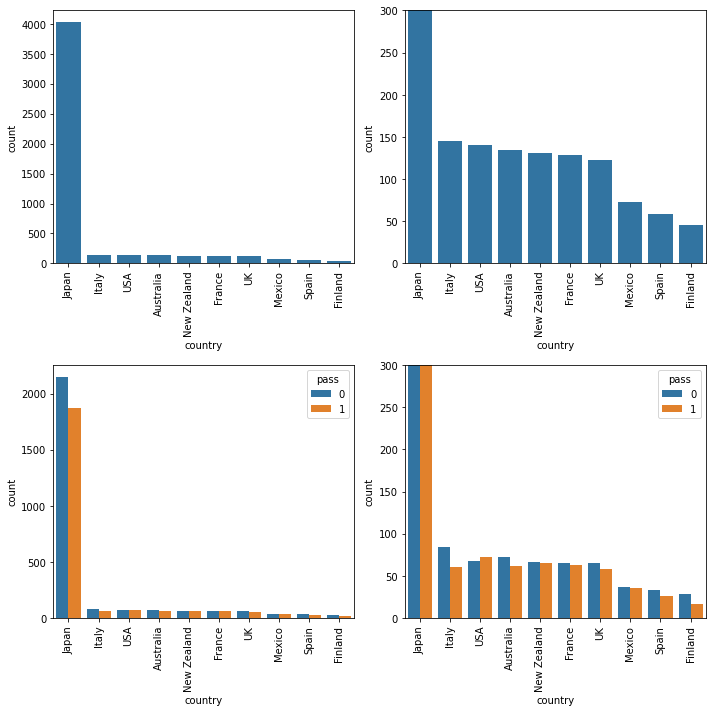

In [7]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))


sns.countplot(
    ax=axes[0,0],
    data = eda_df.sort_values('country_count', ascending=False), 
    x= "country",
    order=eda_df.sort_values('country_count', ascending=False).country.unique(),
    color = sns.color_palette()[0])
axes[0,0].tick_params(axis="x", rotation = 90)

sns.countplot(
    ax = axes[0,1],
    data = eda_df.sort_values('country_count', ascending=False), 
    x= "country",
    order=eda_df.sort_values('country_count', ascending=False).country.unique(),
    color = sns.color_palette()[0])
axes[0,1].tick_params(axis="x", rotation = 90)
axes[0,1].set_ylim(0,300)

sns.countplot(
    ax = axes[1,0],
    data = eda_df.sort_values('country_count', ascending=False), 
    x = "country", 
    hue = "pass", order=eda_df.sort_values('country_count', ascending=False).country.unique(),
    palette=sns.color_palette()[0:2])
axes[1,0].tick_params(axis="x", rotation = 90)

sns.countplot(
    ax = axes[1,1],
    data = eda_df.sort_values('country_count', ascending=False), 
    x = "country", 
    hue = "pass", order=eda_df.sort_values('country_count', ascending=False).country.unique(),
    palette=sns.color_palette()[0:2])
axes[1,1].tick_params(axis="x", rotation = 90)
axes[1,1].set_ylim(0,300)

plt.tight_layout()




and as expected, most participants speak japanese, ranking english at the second and italian at the third place. no seemingly significant differences between passing and failing counts can be seen from the spoken mother tongue, further supporting the above notion, that test ranking seems independent of nationalilty.

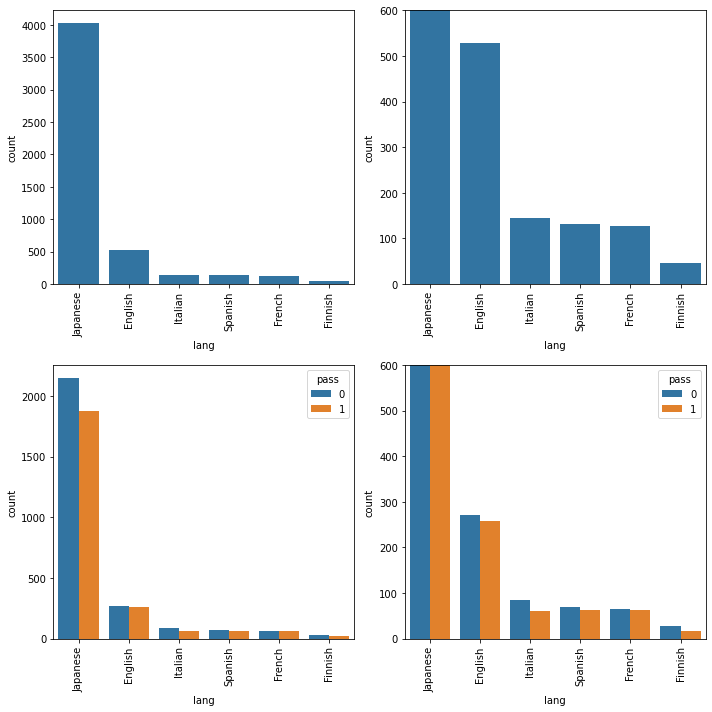

In [8]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))


sns.countplot(
    ax=axes[0,0],
    data = eda_df.sort_values('lang_count', ascending=False), 
    x= "lang",
    order=eda_df.sort_values('lang_count', ascending=False).lang.unique(),
    color = sns.color_palette()[0])
axes[0,0].tick_params(axis="x", rotation = 90)

sns.countplot(
    ax = axes[0,1],
    data = eda_df.sort_values('lang_count', ascending=False), 
    x= "lang",
    order=eda_df.sort_values('lang_count', ascending=False).lang.unique(),
    color = sns.color_palette()[0])
axes[0,1].tick_params(axis="x", rotation = 90)
axes[0,1].set_ylim(0,600)

sns.countplot(
    ax = axes[1,0],
    data = eda_df.sort_values('lang_count', ascending=False), 
    x = "lang",
    hue = "pass", order=eda_df.sort_values('lang_count', ascending=False).lang.unique(),
    palette=sns.color_palette()[0:2])
axes[1,0].tick_params(axis="x", rotation = 90)

sns.countplot(
    ax = axes[1,1],
    data = eda_df.sort_values('lang_count', ascending=False), 
    x = "lang", 
    hue = "pass", order=eda_df.sort_values('lang_count', ascending=False).lang.unique(),
    palette=sns.color_palette()[0:2])
axes[1,1].tick_params(axis="x", rotation = 90)
axes[1,1].set_ylim(0,600)

plt.tight_layout()

as can be seen from the countplot below, most participants didn't use either the dojo class or the test prep and a majority of all failing tests fall under this category, too. Adding the categories which prepared with the dojo-class and those that prepared with both the test prep and the dojo class, we see a majority of prepared students among the passing tests, which participated in the dojo course.

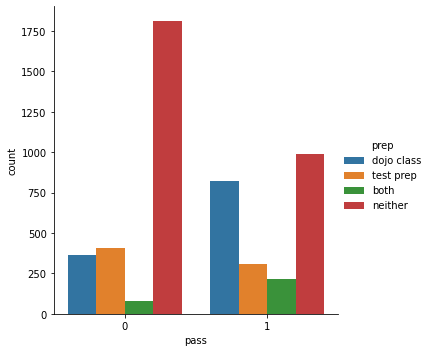

In [9]:
sns.catplot(
    data = eda_df, 
    x = "pass", 
    hue = "prep",  hue_order= ["dojo class","test prep","both","neither"],
    kind="count")

The correlation heatmap shows the strongest correlations with a passing test are with the features "dojo_class", "is_female","hours_studied", "age" and "test_prep".
This implies that

- preparation is the most important feature

- a performance difference between men and women seems to be the case, which might require deeper investigation.

<AxesSubplot:>

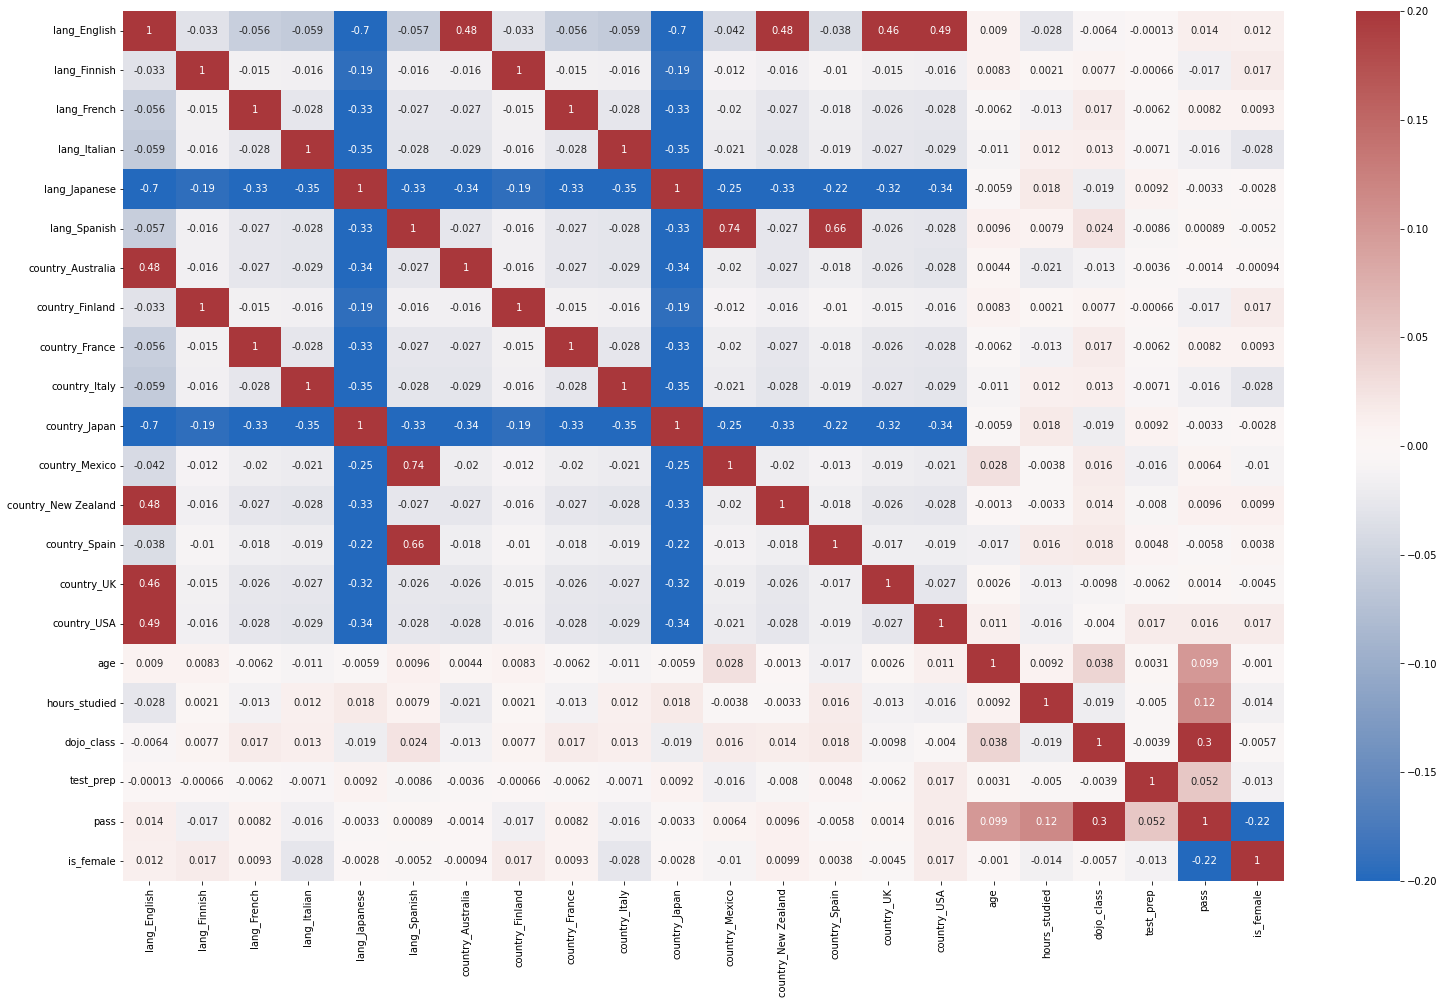

In [10]:
plt.figure(figsize=(26, 16))
corr = df.corr()
sns.heatmap(data=corr,cmap="vlag",vmax=0.2,vmin=-0.2, annot = True)

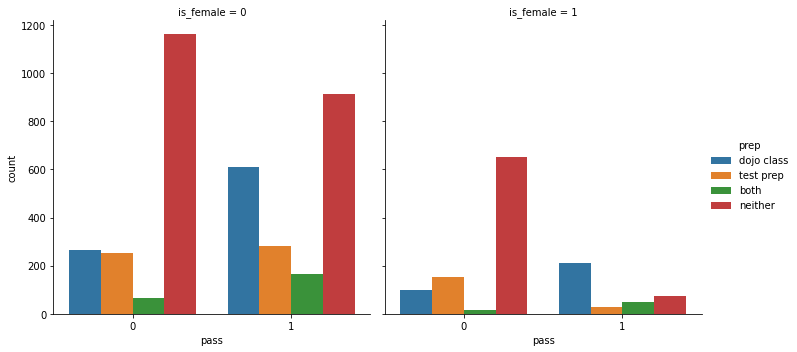

In [11]:
sns.catplot(
    data = eda_df, 
    x = "pass", 
    hue = "prep",  hue_order= ["dojo class","test prep","both","neither"],
    col = "is_female",
    kind="count")

as implied, the total amount of female participants is lower. In addition to this, a much higher percentage of unprepared men seem to succeed than of unprepared women.

## Prediction model

With an overwhelming amount of categorical data and generally weak correlations between numerical values such as "hours_studied" and "age", a decision tree classifier might be the best bet.
I'm directly going for an ensemble method to prevent overfitting. The AdaBoost classifier, an iterative decision tree classifier, iteratively improves its decision power by gradually emphasizing mispredicitons with each iteration.

In [12]:
X = df.drop(["pass"], axis = 1)
y = df["pass"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth= 2), n_estimators= 300)
model.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=300)

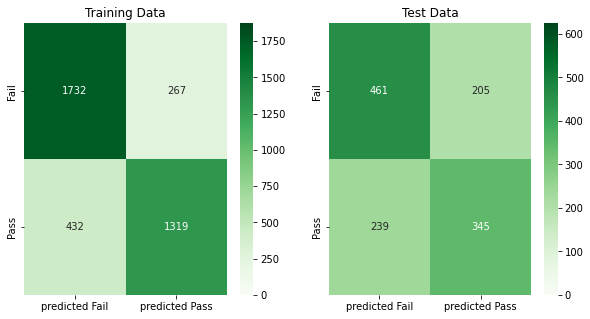

accuracy: 0.6448
recall: 0.5907534246575342
f1 score: 0.6084656084656085
precision: 0.6272727272727273
ROC AUC: 0.6414728084248632
              precision    recall  f1-score   support

           0       0.66      0.69      0.67       666
           1       0.63      0.59      0.61       584

    accuracy                           0.64      1250
   macro avg       0.64      0.64      0.64      1250
weighted avg       0.64      0.64      0.64      1250



In [13]:
y_pred = model.predict(X_test)

fig, axes = plt.subplots(1,2, figsize=(10, 5))
sns.heatmap(
    ax=axes[0],
    vmin = 0,
    vmax = len(X_train)/2,
    cmap = "Greens",
    data=confusion_matrix(y_train,model.predict(X_train)), 
    annot = True,fmt = "g", 
    yticklabels = ["Fail", "Pass"], xticklabels = ["predicted Fail", "predicted Pass"]
    )
axes[0].set_title("Training Data")

sns.heatmap(
    ax=axes[1],
    vmin = 0,
    vmax = len(X_test)/2,
    cmap = "Greens",
    data = confusion_matrix(y_test,y_pred), 
    annot = True,fmt = "g", 
    yticklabels = ["Fail", "Pass"], xticklabels = ["predicted Fail", "predicted Pass"]
    )
axes[1].set_title("Test Data")
plt.show()

print(f"accuracy: {accuracy_score(y_test,y_pred)}")
print(f"recall: {recall_score(y_test,y_pred)}")
print(f"f1 score: {f1_score(y_test,y_pred)}")
print(f"precision: {precision_score(y_test,y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test,y_pred)}")
print(classification_report(y_test,y_pred))

as is visible in the confusion matrices, the relative predictive power over the test data is not as good as over the training data, but allows for a correct prediction of more than 60% of all datapoints.

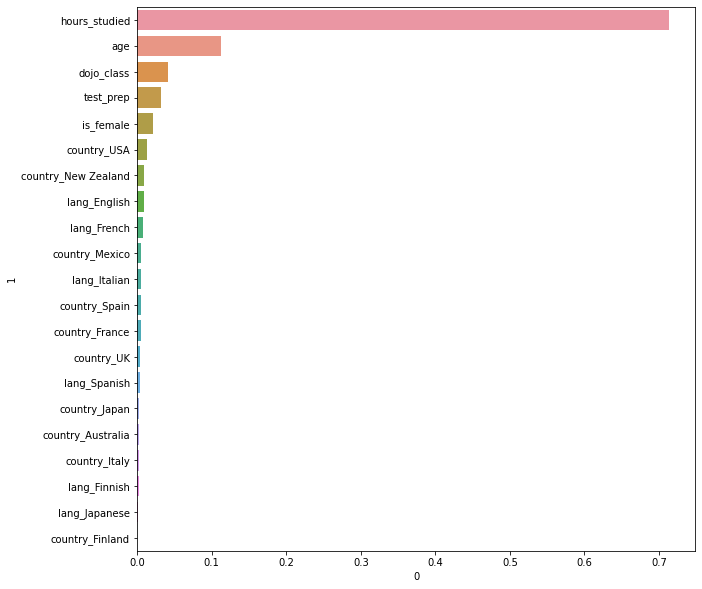

In [14]:
featurelist = list(zip(model.feature_importances_,model.feature_names_in_))
featurelist.sort(reverse=True)
featurelist = pd.DataFrame(featurelist)
plt.figure(figsize=(10,10))
sns.barplot(data=featurelist, x=0, y=1)
plt.show()

Albeit quickly engineered, the model shows the best predictive power is within how long a student has studied, followed by their age, possibly correlating with their relative experience, followed by whether they participated in the dojo-class and their sex (the latter possibly due to a contextual bias in the test field). Without context, not much further can be concluded beside clearly showing, that language and nationality do not have a significant impact on the prediction result. curiously, neither does the test_prep. This means that either the test_prep quality is possibly insufficient, or the implied property of the test_prep feature is false, requiring further context.